In [22]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import os
import sys

In [23]:
#Prereq Stuff
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


def linearKernel(X1, X2):
    return X1 @ X2.T


def polyKernel(X1, X2, degree):
    return (X1 @ X2.T + 1) ** degree


def gaussKernel(X1, X2, width):
    distances = cdist(X1, X2, 'sqeuclidean')
    return np.exp(- distances / (2*(width**2)))


def generateData(n, gen_model):

    # Controlling the random seed will give you the same 
    # random numbers every time you generate the data. 
    # The seed controls the internal random number generator (RNG).
    # Different seeds produce different random numbers. 
    # This can be handy if you want reproducible results for debugging.
    # For example, if your code *sometimes* gives you an error, try
    # to find a seed number (0 or others) that produces the error. Then you can
    # debug your code step-by-step because every time you get the same data.

    # np.random.seed(0)  # control randomness when debugging

    if gen_model == 1 or gen_model == 2:
        # Gen 1 & 2
        d = 2
        w_true = np.ones([d, 1])

        X = np.random.randn(n, d)

        if gen_model == 1:
            y = np.sign(X @ w_true)  # generative model 1
        else:
            y = np.sign((X ** 2) @ w_true - 1)  # generative model 2

    elif gen_model == 3:
        # Gen 3
        X, y = generateMoons(n)

    else:
        raise ValueError("Unknown generative model")

    return X, y


def generateMoons(n, noise=0.1):
    n_samples_out = n // 2
    n_samples_in = n - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), 
         np.append(outer_circ_y, inner_circ_y)]
    ).T
    X += np.random.randn(*X.shape) * noise

    y = np.hstack(
        [-np.ones(n_samples_out, dtype=np.intp), 
         np.ones(n_samples_in, dtype=np.intp)]
    )[:, None]
    return X, y


def plotPoints(X, y):
    # plot the data points from two classes
    X0 = X[y.flatten() >= 0]
    X1 = X[y.flatten() < 0]

    plt.scatter(X0[:, 0], X0[:, 1], marker='x', label='class -1')
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', label='class +1')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, y, w, w0, classify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = classify(np.c_[xx.ravel(), yy.ravel()], w, w0)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotAdjModel(X, y, a, a0, kernel_func, adjClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = adjClassify(np.c_[xx.ravel(), yy.ravel()], a, a0, X, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotDualModel(X, y, a, b, lamb, kernel_func, dualClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = dualClassify(np.c_[xx.ravel(), yy.ravel()], a, b, X, y, 
                     lamb, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()

    return


def plotDigit(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return



In [24]:
#temp

#q2c
def adjClassify(Xtest, a, a0, X, kernel_func):
    return np.sign( (kernel_func(Xtest,X)@ a + a0)  )

    

Optimized weights: [[-4.66783947e-01]
 [-5.44296590e-01]
 [-4.78423074e-01]
 [-6.00916496e-01]
 [-4.71659315e-01]
 [-5.04694138e-01]
 [-5.83108737e-01]
 [-5.34076902e-01]
 [-5.76663496e-01]
 [-4.09522494e-01]
 [-4.57590886e-01]
 [-3.02805041e-01]
 [-4.48632965e-01]
 [-4.34071887e-01]
 [-3.45075773e-01]
 [-3.34540820e-01]
 [-3.34555805e-01]
 [-1.68950360e-01]
 [-1.91898852e-01]
 [-2.26445354e-01]
 [-1.92887902e-01]
 [-1.42824513e-01]
 [-1.60221843e-01]
 [-1.78262703e-02]
 [-6.18618003e-02]
 [-1.65051378e-01]
 [-4.89970984e-05]
 [ 2.91337228e-02]
 [ 9.11144603e-02]
 [-3.66755591e-01]
 [-1.08763034e-01]
 [-2.46215164e-01]
 [-1.43370320e-01]
 [-1.17668410e-01]
 [-2.62043690e-01]
 [-2.05219569e-01]
 [-2.06628728e-01]
 [-1.98419043e-01]
 [-1.03717852e-01]
 [-1.28201512e-01]
 [-5.53294757e-02]
 [-1.59318155e-01]
 [-1.77839589e-01]
 [-2.49267233e-01]
 [-9.35027157e-02]
 [-3.22336358e-01]
 [-3.29650527e-01]
 [-2.31240026e-01]
 [-3.69791924e-01]
 [-3.61509825e-01]
 [ 2.73251353e-01]
 [ 4.9532925

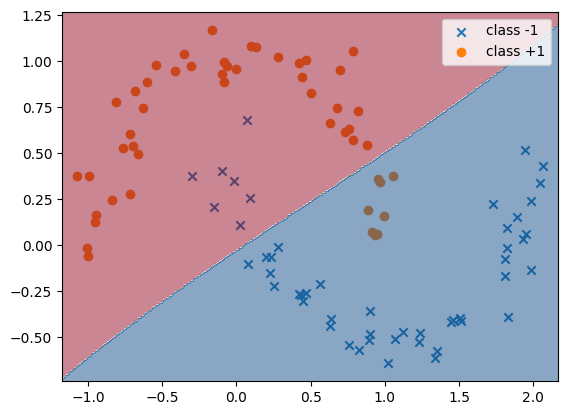

In [25]:
#q2a

def objective_function(params, y, lamb, K):
    n = len(y)
    
    alpha = params[:n]
    alpha = alpha[:,None]
    alpha0 = params[n]
    
    linear_combination = (K @ alpha) + alpha0
    loss = np.sum(np.logaddexp(0, -y * linear_combination))
    
    regularization = (lamb / 2) * (alpha.T @ K @ alpha).item()
    return loss + regularization


def adjBinDev(X, y, lamb, kernel_func):
    n, d = X.shape
    K = kernel_func(X, X)
    initial_params = np.ones(n + 1)
    
    result = minimize(objective_function, initial_params, args=(y, lamb, K))
    
    a = result.x[:-1][:,None]
    a0 = result.x[-1]

    return a, a0



#  usage
X,y = generateData(100,3)
lamb = 1
kernel_func = lambda X1, X2 : gaussKernel(X1,X2,2)

a, a0 = adjBinDev(X, y, lamb,kernel_func)

print("Optimized weights:", a)
print("Optimized bias:", a0) 

plotAdjModel(X,y,a,a0,kernel_func,adjClassify)

Optimized weights: [-1.21666528e-02 -2.37799517e-03  3.07256261e-03 -1.50975251e-02
 -1.44722712e-02 -1.48672393e-02 -1.05889344e-02 -1.63115854e-02
 -1.41368375e-02 -1.17663073e-02 -1.61558307e-02 -1.60570446e-02
 -8.01388853e-03 -1.98047916e-02 -2.31543254e-03 -1.12286654e-02
 -9.54753557e-03  4.28755804e-03 -6.59763701e-03 -1.27081572e-02
 -1.29815986e-02 -2.26411736e-02 -1.76973702e-02 -1.26727814e-02
 -3.21049898e-02 -3.52571778e-02 -3.39845438e-02 -4.67358480e-02
 -4.07337216e-02 -4.98141276e-02 -4.78904292e-02 -4.93365491e-02
 -4.63055699e-02 -5.96064908e-02 -5.97516794e-02 -6.88618243e-02
 -4.92926882e-02 -4.54169778e-02 -4.71237542e-02 -3.78161342e-02
 -1.98097683e-02 -1.73631370e-02 -2.08709873e-02 -1.39993846e-02
  2.90941867e-02  9.65778423e-03  2.40690718e-02  4.26763681e-02
  6.22828481e-02  6.28379306e-02 -2.58620508e-02 -2.15997551e-02
 -1.87311208e-02 -1.80971843e-03 -1.59109173e-02 -7.60560186e-06
  9.66968796e-03  2.02581377e-02  2.32316060e-02  1.20894808e-02
  4.37

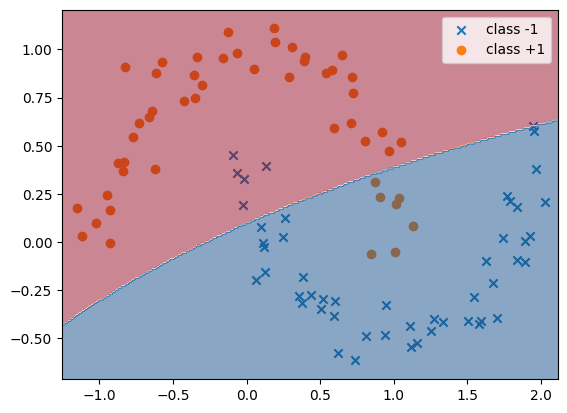

In [26]:
#q2b

def adjHinge(X, y, lamb, kernel_func, stabilizer=1e-5):
    n, d = X.shape
    K = kernel_func(X, X) 
    

    P = np.zeros((2*n + 1, 2*n+1)) 
    P[:n, :n] = lamb * K  # Kernel matrix for alpha terms
    P = matrix(P + stabilizer * np.eye(2*n+1))  # Stabilization

    q = matrix(np.hstack([np.zeros(n + 1),  np.ones(n)]))
    
    # Create G matrix
    # G1: For the non-negativity constraints of the slack variables 
    G11 = np.zeros([n,n]) #for 1, its nxd
    G12 = np.zeros([n,1])
    G13 = -np.eye(n)
    G1 = np.hstack([G11,G12,G13])
    
    # G2: For the hinge constraints
    G21 = -y * K
    G22 = -y * np.ones([n,1])
    G23 = -np.eye(n)
    G2 = np.hstack([G21,G22,G23])

    G = np.vstack([G1, G2])  # Stack G1 and G2 to form the full G matrix

    # Create the h vector
    h = np.concatenate([np.zeros(n), -np.ones(n)]) 

    # Convert 
    G = matrix(G)
    h = matrix(h)

    solution = solvers.qp(P, q, G, h)

    # Extract solutions for α and α_0
    alphas = np.array(solution['x'][:n])
    alpha0 = np.array(solution['x'][n])

    return alphas, alpha0

# Example usage
X,y = generateData(100,3)
lamb = 1# Regularization parameter

kernel_func = lambda X1, X2 : polyKernel(X1,X2,2)

a, a0 = adjHinge(X, y, lamb,kernel_func)

print("Optimized weights:", a.flatten())
print("Optimized bias:", a0)

plotAdjModel(X,y,a,a0,kernel_func,adjClassify)

In [27]:
#q2c
def adjClassify(Xtest, a, a0, X, kernel_func):
    yhat = np.sign( (kernel_func(Xtest,X)@ a + a0)  )




In [28]:
#q2d

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def predict(X, alphas, alpha0, kernel, X_support):
    K = kernel(X_support, X)
    predictions = K.T.dot(alphas) + alpha0
    return np.sign(predictions)

def sunExperimentsKernel():
    n_runs = 10 
    n_train = 100
    n_test = 1000
    lamb = 0.001
    kernel_list = [linearKernel,
                   lambda X1, X2: polyKernel(X1, X2, 2),
                   lambda X1, X2: polyKernel(X1, X2, 3),
                   lambda X1, X2: gaussKernel(X1, X2, 1.0),
                   lambda X1, X2: gaussKernel(X1, X2, 0.5)]
    
    gen_model_list = [1, 2, 3]
    
    train_acc_bindev = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    test_acc_bindev = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    train_acc_hinge = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    test_acc_hinge = np.zeros([len(kernel_list), len(gen_model_list), n_runs])
    
    for r in range(n_runs):
        for i, kernel in enumerate(kernel_list):
            for j, gen_model in enumerate(gen_model_list):
                Xtrain, ytrain = generateData(n=n_train, gen_model=gen_model)
                Xtest, ytest = generateData(n=n_test, gen_model=gen_model)
                
                # BinDev model
                a, a0 = adjBinDev(Xtrain, ytrain, lamb, kernel)
                train_pred_bindev = predict(Xtrain, a, a0, kernel, Xtrain)
                test_pred_bindev = predict(Xtest, a, a0, kernel, Xtrain)
                train_acc_bindev[i, j, r] = compute_accuracy(ytrain, train_pred_bindev)
                test_acc_bindev[i, j, r] = compute_accuracy(ytest, test_pred_bindev)
                
                # Hinge model
                
                a, a0 = adjHinge(Xtrain, ytrain, lamb, kernel)
                train_pred_hinge = predict(Xtrain, a, a0, kernel, Xtrain)
                test_pred_hinge = predict(Xtest, a, a0, kernel, Xtrain)
                train_acc_hinge[i, j, r] = compute_accuracy(ytrain, train_pred_hinge)
                test_acc_hinge[i, j, r] = compute_accuracy(ytest, test_pred_hinge)
                

    # Compute average accuracies over runs
    train_acc = np.hstack([np.mean(train_acc_bindev,axis = 2), np.mean(train_acc_hinge,axis=2)])
    test_acc = np.hstack([np.mean(test_acc_bindev,axis = 2), np.mean(test_acc_hinge,axis=2)])
    
    # Return or print results
    return train_acc, test_acc


solvers.options['show_progress'] = False

# Call function
train_accuracy, test_accuracy = sunExperimentsKernel()

#print(train_accuracy.shape, test_accuracy.shape)

print(train_accuracy)
print(test_accuracy)


# Print results
print("Average Train Accuracies - Binary Deviance:", train_accuracy[0])
print("Average Test Accuracies - Binary Deviance:", test_accuracy[0])
print("Average Train Accuracies - Hinge:", train_accuracy[1])
print("Average Test Accuracies - Hinge:", train_accuracy[1])



[[0.999 0.57  0.87  0.998 0.622 0.866]
 [1.    1.    0.876 1.    1.    0.88 ]
 [1.    1.    1.    1.    1.    1.   ]
 [0.999 1.    0.999 0.999 0.999 1.   ]
 [1.    1.    1.    1.    1.    1.   ]]
[[0.9915 0.5346 0.8805 0.99   0.5987 0.8777]
 [0.9778 0.9803 0.88   0.9755 0.9745 0.8797]
 [0.9759 0.969  0.9964 0.975  0.9692 0.9917]
 [0.9794 0.9737 0.9976 0.9674 0.9727 0.9948]
 [0.9555 0.9549 0.9979 0.9461 0.9485 0.9975]]
Average Train Accuracies - Binary Deviance: [0.999 0.57  0.87  0.998 0.622 0.866]
Average Test Accuracies - Binary Deviance: [0.9915 0.5346 0.8805 0.99   0.5987 0.8777]
Average Train Accuracies - Hinge: [1.    1.    0.876 1.    1.    0.88 ]
Average Test Accuracies - Hinge: [1.    1.    0.876 1.    1.    0.88 ]
